# **Image captioning with Deep Reinforcement learning**

In [ ]:
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import nltk
import random

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F

import tensorflow as tf

from torchsummary import summary

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Working on: ", device)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

max_seq_len = 17

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()



Working on:  cuda:0


In [ ]:
!pip install pycocoevalcap
!pip install python-docx

     |████████████████████████████████| 104.3MB 31kB/s 
     |████████████████████████████████| 5.6MB 8.4MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-cp37-none-any.whl size=184508 sha256=772d8803c86d3e0b05b72e2314432becbdf154701948bd98216c33468cfbf7f1
  Stored in directory: /root/.cache/pip/wheels/a6/90/f1/a7cb70b38633ae04e7fb963b1c70f63fd6fc01c075b8230adc
Successfully built python-docx


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1DS16YS4MW2WTHgWD6q2LAfrRrjHzGTx5' # for https://drive.google.com/file/d/1DS16YS4MW2WTHgWD6q2LAfrRrjHzGTx5/view?usp=sharing
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('policyNetwork.pt')

id2='1dQZNNl7hB09JQbfssbAy8QYc9cy6SQX7' # for https://drive.google.com/file/d/1dQZNNl7hB09JQbfssbAy8QYc9cy6SQX7/view?usp=sharing
downloaded = drive.CreateFile({'id': id2})
downloaded.GetContentFile('rewardNetwork.pt')


id3='1uNJN4ind1PZ_RTfSj5jIFXbqafWz4vxg' # for https://drive.google.com/file/d/1uNJN4ind1PZ_RTfSj5jIFXbqafWz4vxg/view?usp=sharing
downloaded = drive.CreateFile({'id': id3})
downloaded.GetContentFile('valueNetwork.pt')

In [ ]:
"""
Computes the BLEU, ROUGE, METEOR, and CIDER
using the COCO metrics scripts
"""
import argparse
import logging

# this requires the coco-caption package, https://github.com/tylin/coco-caption
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor


parser = argparse.ArgumentParser(
    description="""This takes two text files and a path the references (source, references),
     computes bleu, meteor, rouge and cider metrics""", formatter_class=argparse.RawTextHelpFormatter)
parser.add_argument("hypothesis", type=argparse.FileType('r'),
                help="The hypothesis files")
parser.add_argument("references", type=argparse.FileType('r'), nargs="+",
                help="Path to all the reference files")


def load_textfiles(references, hypothesis):
    print ("The number of references is {}".format(len(references)))
    refs = {idx: [lines.strip()] for (idx, lines) in enumerate(references)}
    hypo = {idx: [lines.strip()] for (idx, lines) in enumerate(hypothesis)}
    # take out newlines before creating dictionary
#     raw_refs = [map(str.strip, r) for r in zip(*references)]
#     refs = {idx: rr for idx, rr in enumerate(raw_refs)}
    # sanity check that we have the same number of references as hypothesis
    if len(hypo) != len(refs):
        raise ValueError("There is a sentence number mismatch between the inputs", len(hypo), len(refs))
    return refs, hypo


def score(ref, hypo):
    """
    ref, dictionary of reference sentences (id, sentence)
    hypo, dictionary of hypothesis sentences (id, sentence)
    score, dictionary of scores
    """
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores



# **Loading coco dataset**

In [ ]:
#https://www.kaggle.com/gauravduttakiit/coco-captioning/download
#http://cs231n.stanford.edu/coco_captioning.zip
dataset_zip = tf.keras.utils.get_file('coco_captioning.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://cs231n.stanford.edu/coco_captioning.zip',
                                      extract = True)
#!unzip coco_captioning.zip


1035214848/1035210391 [==============================] - 82s 0us/step


In [ ]:
BASE_DIR = './coco_captioning/'

import h5py

def load_coco_data(base_dir=BASE_DIR,
                   max_train=None,
                   pca_features=True):
    data = {}
    caption_file = os.path.join(base_dir, 'coco2014_captions.h5')
    with h5py.File(caption_file, 'r') as f:
        for k, v in f.items():
            data[k] = np.asarray(v)

    if pca_features:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7_pca.h5')
    else:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7.h5')
    with h5py.File(train_feat_file, 'r') as f:
        data['train_features'] = np.asarray(f['features'])

    if pca_features:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7_pca.h5')
    else:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7.h5')
    with h5py.File(val_feat_file, 'r') as f:
        data['val_features'] = np.asarray(f['features'])

    dict_file = os.path.join(base_dir, 'coco2014_vocab.json')
    with open(dict_file, 'r') as f:
        dict_data = json.load(f)
        for k, v in dict_data.items():
            data[k] = v

    train_url_file = os.path.join(base_dir, 'train2014_urls.txt')
    with open(train_url_file, 'r') as f:
        train_urls = np.asarray([line.strip() for line in f])
    data['train_urls'] = train_urls

    val_url_file = os.path.join(base_dir, 'val2014_urls.txt')
    with open(val_url_file, 'r') as f:
        val_urls = np.asarray([line.strip() for line in f])
    data['val_urls'] = val_urls

    # Maybe subsample the training data
    if max_train is not None:
        num_train = data['train_captions'].shape[0]
        mask = np.random.randint(num_train, size=max_train)
        data['train_captions'] = data['train_captions'][mask]
        data['train_image_idxs'] = data['train_image_idxs'][mask]

    return data


def decode_captions(captions, idx_to_word):
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]
    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != '<NULL>':
                words.append(word)
            if word == '<END>':
                break
        decoded.append(' '.join(words))
    if singleton:
        decoded = decoded[0]
    return decoded


def sample_coco_minibatch(data, batch_size=100, split='train'):
    split_size = data['%s_captions' % split].shape[0]
    mask = np.random.choice(split_size, batch_size)
    captions = data['%s_captions' % split][mask]
    image_idxs = data['%s_image_idxs' % split][mask]
    image_features = data['%s_features' % split][image_idxs]
    urls = data['%s_urls' % split][image_idxs]
    return captions, image_features, urls

In [ ]:
data = load_coco_data(pca_features=True)

data["train_captions_lens"] = np.zeros(data["train_captions"].shape[0])
data["val_captions_lens"] = np.zeros(data["val_captions"].shape[0])
for i in range(data["train_captions"].shape[0]):
    data["train_captions_lens"][i] = np.nonzero(data["train_captions"][i] == 2)[0][0] + 1
for i in range(data["val_captions"].shape[0]):
    data["val_captions_lens"][i] = np.nonzero(data["val_captions"][i] == 2)[0][0] + 1


# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63
train_captions_lens <class 'numpy.ndarray'> (400135,) float64
val_captions_lens <class 'numpy.ndarray'> (195954,) float64


##Attention Network

In [ ]:

class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

# **Policy Network**

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(PolicyNetwork, self).__init__()

        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}

        vocab_size = len(word_to_idx)

        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)

        self.cnn2linear = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(wordvec_dim, hidden_dim, batch_first=True)
        self.linear2vocab = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        input_captions = self.caption_embedding(captions)
        hidden_init = self.cnn2linear(features)
        cell_init = torch.zeros_like(hidden_init)
        output, _ = self.lstm(input_captions, (hidden_init, cell_init))
        output = self.linear2vocab(output)
        return output

# **Reward and Value Networks**

In [ ]:
class RewardNetworkRNN(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(RewardNetworkRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        vocab_size = len(word_to_idx)

        self.hidden_cell = torch.zeros(1, 1, self.hidden_dim).to(device)

        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        self.gru = nn.GRU(wordvec_dim, hidden_dim)

    def forward(self, captions):
        input_captions = self.caption_embedding(captions)
        output, self.hidden_cell = self.gru(input_captions.view(len(input_captions) ,1, -1), self.hidden_cell)
        return output

class RewardNetwork(nn.Module):
    def __init__(self, word_to_idx):
        super(RewardNetwork, self).__init__()
        self.rewrnn = RewardNetworkRNN(word_to_idx)
        self.visual_embed = nn.Linear(512, 512)
        self.semantic_embed = nn.Linear(512, 512)

    def forward(self, features, captions):
        for t in range(captions.shape[1]):
            rrnn = self.rewrnn(captions[:, t])
        rrnn = rrnn.squeeze(0).squeeze(1)
        se = self.semantic_embed(rrnn)
        ve = self.visual_embed(features)
        return ve, se

In [ ]:
class ValueNetworkRNN(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(ValueNetworkRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        vocab_size = len(word_to_idx)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_dim).to(device), torch.zeros(1, 1, self.hidden_dim).to(device))

        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        self.lstm = nn.LSTM(wordvec_dim, hidden_dim)

    def forward(self, captions):
        input_captions = self.caption_embedding(captions)
        output, self.hidden_cell = self.lstm(input_captions.view(len(input_captions) ,1, -1), self.hidden_cell)
        return output

class ValueNetwork(nn.Module):
    def __init__(self, word_to_idx):
        super(ValueNetwork, self).__init__()
        self.valrnn = ValueNetworkRNN(word_to_idx)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 1)

    def forward(self, features, captions):
        for t in range(captions.shape[1]):
            vrnn = self.valrnn(captions[:, t])
        vrnn = vrnn.squeeze(0).squeeze(1)
        state = torch.cat((features, vrnn), dim=1)
        output = self.linear1(state)
        output = self.linear2(output)
        return output

# **Generating Captions**

In [ ]:
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('policyNetwork.pt'))
policyNet.train(mode=False)

valueNet = ValueNetwork(data["word_to_idx"]).to(device)
valueNet.load_state_dict(torch.load('valueNetwork.pt'))
valueNet.train(mode=False)

ValueNetwork(
  (valrnn): ValueNetworkRNN(
    (caption_embedding): Embedding(1004, 512)
    (lstm): LSTM(512, 512)
  )
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
def GenerateCaptions(features, captions, model):
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    gen_caps = torch.tensor(captions[:, 0:1], device=device).long()
    for t in range(max_seq_len-1):
        output = model(features, gen_caps)
        gen_caps = torch.cat((gen_caps, output[:, -1:, :].argmax(axis=2)), axis=1)
    return gen_caps

In [ ]:
def GenerateCaptionsWithBeamSearch(features, captions, model, beamSize=5):
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    gen_caps = torch.tensor(captions[:, 0:1], device=device).long()
    candidates = [(gen_caps, 0)]
    for t in range(max_seq_len-1):
        next_candidates = []
        for c in range(len(candidates)):
            output = model(features, candidates[c][0])
            probs, words = torch.topk(output[:, -1:, :], beamSize)
            for i in range(beamSize):
                cap = torch.cat((candidates[c][0], words[:, :, i]), axis=1)
                score = candidates[c][1] - torch.log(probs[0, 0, i]).item()
                next_candidates.append((cap, score))
        ordered_candidates = sorted(next_candidates, key=lambda tup:tup[1])
        candidates = ordered_candidates[:beamSize]
    return candidates

def GenerateCaptionsWithBeamSearchValueScoring(features, captions, model, beamSize=5):
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    gen_caps = torch.tensor(captions[:, 0:1], device=device).long()
    candidates = [(gen_caps, 0)]
    for t in range(max_seq_len-1):
        next_candidates = []
        for c in range(len(candidates)):
            output = model(features, candidates[c][0])
            probs, words = torch.topk(output[:, -1:, :], beamSize)
            for i in range(beamSize):
                cap = torch.cat((candidates[c][0], words[:, :, i]), axis=1)
                value = valueNet(features.squeeze(0), cap).detach()
                score = candidates[c][1] - 0.6*value.item() -0.4*torch.log(probs[0, 0, i]).item()
                next_candidates.append((cap, score))
        ordered_candidates = sorted(next_candidates, key=lambda tup:tup[1])
        candidates = ordered_candidates[:beamSize]
    return candidates

In [ ]:
small_data = load_coco_data(max_train=50000)

In [ ]:
with torch.no_grad():
    max_seq_len = 17
    ref_caps = []

    captions, features, urls = sample_coco_minibatch(small_data, batch_size=100, split='val')
    for i in range(100):
        gen_caps = []
        gen_caps.append(GenerateCaptions(features[i:i+1], captions[i:i+1], policyNet)[0])
        gen_caps.append(GenerateCaptionsWithBeamSearch(features[i:i+1], captions[i:i+1], policyNet)[0][0][0])
        pred_caps = GenerateCaptionsWithBeamSearchValueScoring(features[i:i+1], captions[i:i+1], policyNet)[0][0][0]
        gen_caps.append(pred_caps)
        ref_caps.append(pred_caps)
        decoded_tru_caps = decode_captions(captions[i], data["idx_to_word"])
        f = open("truth3.txt", "a")
        f.write(decoded_tru_caps + "\n")
        f.close()

        decoded_gen_caps = decode_captions(gen_caps[0], data["idx_to_word"])
        f = open("greedy3.txt", "a")
        f.write(decoded_gen_caps + "\n")
        f.close()

        decoded_gen_caps = decode_captions(gen_caps[1], data["idx_to_word"])
        f = open("beam3.txt", "a")
        f.write(decoded_gen_caps + "\n")
        f.close()

        decoded_gen_caps = decode_captions(gen_caps[2], data["idx_to_word"])
        f = open("policyvalue3.txt", "a")
        f.write(decoded_gen_caps + "\n")
        f.close()
        try:
            plt.imshow(image_from_url(urls[i]))
            plt.show()
        except:
            continue
        print(urls[i])
        print(decode_captions(gen_caps[2], data["idx_to_word"]))

# **Visualization**

Actual: <START> a woman is walking in the ocean surf <END>
Generated:  <START> a man that is standing on a surfboard in the <UNK> water <END>
http://farm3.staticflickr.com/2742/5804710618_6c324b1259_z.jpg


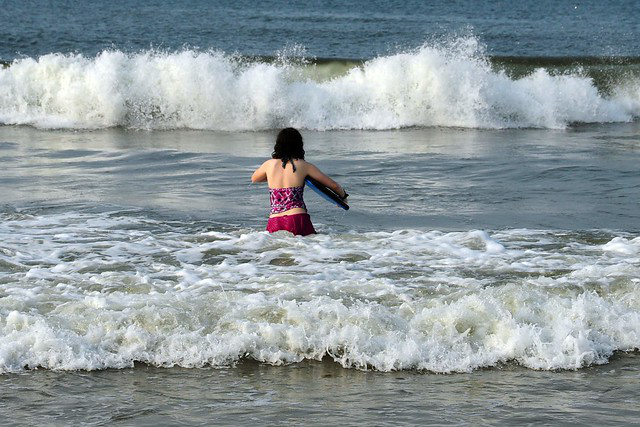

In [ ]:
from PIL import Image

ip = 25

print('Actual:',decode_captions(captions[ip], data["idx_to_word"]))
print('Generated: ',decode_captions(ref_caps[ip], data["idx_to_word"]))
print(urls[ip])
try:
  img_file = tf.keras.utils.get_file('image'+str(ip),origin = urls[ip],
                                          extract = True)
except:
  print("File not downloaded")

Image.open(img_file)



# **Saving results in output file**

In [ ]:
import docx
mydoc = docx.Document()

for ip in range(50):
    str1 = 'Actual:'+str(decode_captions(captions[ip], data["idx_to_word"]))
    str2 = 'Generated: '+ decode_captions(ref_caps[ip], data["idx_to_word"])
    mydoc.add_heading("Test Sample : "+ str(ip),1)

    #Image.open(img_file)
    try:
        img_file = tf.keras.utils.get_file('image'+str(ip),origin = urls[ip],
                                          extract = True)
        mydoc.add_picture(img_file, width=docx.shared.Inches(7), height=docx.shared.Inches(5))
    except:
        mydoc.add_paragraph(urls[ip]+"\n")

    mydoc.add_paragraph(str1+"\n"+str2)


mydoc.save("./Results.docx")

# **Evaluating our model**

In [ ]:
def BLEU_score(gt_caption, sample_caption, w):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ')
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ')
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [w])
    return BLEUscore

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

In [ ]:

caps0 = []
caps1 = []
caps2 = []
caps3 = []
f = open("truth3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps0.append(x)
f = open("greedy3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps1.append(x)
f = open("beam3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps2.append(x)
f = open("policyvalue3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps3.append(x)

In [ ]:
b1, b2, b3 = 0, 0, 0
for w in range(1, 5):
    for i in range(len(caps0)):
        b1 += BLEU_score(caps0[i], caps1[i], w)
        b2 += BLEU_score(caps0[i], caps2[i], w)
        b3 += BLEU_score(caps0[i], caps3[i], w)
    b1 /= len(caps0)
    b2 /= len(caps0)
    b3 /= len(caps0)
    print("Greedy BLEU-" + str(w), ":", b1)
    print("Beam BLEU-" + str(w), ":", b2)
    print("Agent BLEU-" + str(w), ":", b3)
    print()

Greedy BLEU-1 : 0.22373149363580644
Beam BLEU-1 : 0.2759368102238077
Agent BLEU-1 : 0.27153170206306015

Greedy BLEU-2 : 0.08191933406757998
Beam BLEU-2 : 0.11623834730830099
Agent BLEU-2 : 0.11172316164264826

Greedy BLEU-3 : 0.03610109623641688
Beam BLEU-3 : 0.05622664017184606
Agent BLEU-3 : 0.0528061381251165

Greedy BLEU-4 : 0.019118896509221342
Beam BLEU-4 : 0.030492174050624828
Agent BLEU-4 : 0.028087557037116864



In [ ]:
ref, hypo = load_textfiles(caps0, caps3)
print(score(ref, hypo))

The number of references is 100
{'testlen': 1031, 'reflen': 965, 'guess': [1031, 931, 831, 731], 'correct': [309, 80, 26, 9]}
ratio: 1.0683937823823126
{'Bleu_1': 0.2997090203682835, 'Bleu_2': 0.1604796838396728, 'Bleu_3': 0.09305452175433146, 'Bleu_4': 0.0561221621490678, 'METEOR': 0.11879341120770921, 'ROUGE_L': 0.28445045376790135, 'CIDEr': 0.5472925507287226}


# **Training Policy Network**

In [ ]:
pretrained = False

policyNetwork = PolicyNetwork(data["word_to_idx"]).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(policyNetwork.parameters(), lr=0.0001)


In [ ]:
batch_size = 100
bestLoss = 0.5
#0.006700546946376562

for epoch in range(250000, 350000):
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    captions_in = torch.tensor(captions[:, :-1], device=device).long()
    captions_ou = torch.tensor(captions[:, 1:], device=device).long()
    output = policyNetwork(features, captions_in)

    loss = 0
    for i in range(batch_size):
        caplen = np.nonzero(captions[i] == 2)[0][0] + 1
        loss += (caplen/batch_size)*criterion(output[i][:caplen], captions_ou[i][:caplen])

    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(policyNetwork.state_dict(), "policyNetwork.pt")
        print("epoch:", epoch, "loss:", loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# **Training Reward and Value network**

In [ ]:
rewardNetwork = RewardNetwork(data["word_to_idx"]).to(device)
optimizer = optim.Adam(rewardNetwork.parameters(), lr=0.001)

# https://cs230-stanford.github.io/pytorch-nlp.html#writing-a-custom-loss-function
def VisualSemanticEmbeddingLoss(visuals, semantics):
    beta = 0.2
    N, D = visuals.shape

    visloss = torch.mm(visuals, semantics.t())
    visloss = visloss - torch.diag(visloss).unsqueeze(1)
    visloss = visloss + (beta/N)*(torch.ones((N, N)).to(device) - torch.eye(N).to(device))
    visloss = F.relu(visloss)
    visloss = torch.sum(visloss)/N

    semloss = torch.mm(semantics, visuals.t())
    semloss = semloss - torch.diag(semloss).unsqueeze(1)
    semloss = semloss + (beta/N)*(torch.ones((N, N)).to(device) - torch.eye(N).to(device))
    semloss = F.relu(semloss)
    semloss = torch.sum(semloss)/N

    return visloss + semloss

In [ ]:
batch_size = 50
bestLoss = 10000

for epoch in range(50000):
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float()
    captions = torch.tensor(captions, device=device).long()
    ve, se = rewardNetwork(features, captions)
    loss = VisualSemanticEmbeddingLoss(ve, se)

    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(rewardNetwork.state_dict(), "rewardNetwork.pt")
        print("epoch:", epoch, "loss:", loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    rewardNetwork.rewrnn.hidden_cell.detach_()

In [ ]:
def GetRewards(features, captions, model):
    visEmbeds, semEmbeds = model(features, captions)
    visEmbeds = F.normalize(visEmbeds, p=2, dim=1)
    semEmbeds = F.normalize(semEmbeds, p=2, dim=1)
    rewards = torch.sum(visEmbeds*semEmbeds, axis=1).unsqueeze(1)
    return rewards

In [ ]:

rewardNet = RewardNetwork(data["word_to_idx"]).to(device)
rewardNet.load_state_dict(torch.load('rewardNetwork.pt'))
for param in rewardNet.parameters():
    param.require_grad = False
print(rewardNet)

policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('policyNetwork.pt'))
for param in policyNet.parameters():
    param.require_grad = False
print(policyNet)

valueNetwork = ValueNetwork(data["word_to_idx"]).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(valueNetwork.parameters(), lr=0.0001)
valueNetwork.train(mode=True)

In [ ]:
batch_size = 50
bestLoss = 10000
max_seq_len = 17

for epoch in range(50000):
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float()

    # Generate captions using the policy network
    captions = GenerateCaptions(features, captions, policyNet)

    # Compute the reward of the generated caption using reward network
    rewards = GetRewards(features, captions, rewardNet)

    # Compute the value of a random state in the generation process
#     print(features.shape, captions[:, :random.randint(1, 17)].shape)
    values = valueNetwork(features, captions[:, :random.randint(1, 17)])

    # Compute the loss for the value and the reward
    loss = criterion(values, rewards)

    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(valueNetwork.state_dict(), "valueNetwork.pt")
        print("epoch:", epoch, "loss:", loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    valueNetwork.valrnn.hidden_cell[0].detach_()
    valueNetwork.valrnn.hidden_cell[1].detach_()
    rewardNet.rewrnn.hidden_cell.detach_()